# **CRUSHgebra**

The goal of this project is to design and train a single neural network that can perform two different tasks simultaneously (Multi-Task Learning).
1. Task 1 is regression, aiming to predict the student's final grade, `G3` (a number from 0 to 20).
2. Task 2 is classification, aiming to determine whether the student is in a `romantic` relationship or not.
   
This notebook fully covers all the code and experiments included in this repository through Python scripts. The interpreter used to run the code snippets in this notebook was 3.14; it was the same interpreter used for the entire project. After ensuring that you are using Python 3.14, install all the necessary libraries for this project:

In [1]:
!pip install -U matplotlib numpy pandas scikit-learn torch ucimlrepo

Here I will list all the imports used throughout the notebook (and project) so that I will not need to need to run any functional code snippet twice:

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import torch
import torch.nn as nn

from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from ucimlrepo import fetch_ucirepo

Now let's start by using UC Irvine's Python API to retrieve the "Student Performance" dataset:

In [3]:
student_performance = fetch_ucirepo(name="Student Performance")
student_performance.metadata.additional_info.summary

'This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).'

### Attributes of the dataset:
1. school: student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
2. sex: student's sex (binary: "F" - female or "M" - male)
3. age: student's age (numeric: from 15 to 22)
4. address: student's home address type (binary: "U" - urban or "R" - rural)
5. famsize: family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
6. Pstatus: parent's cohabitation status (binary: "T" - living together or "A" - apart)
7. Medu: mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
8. Fedu: father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
9. Mjob: mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
10. Fjob: father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
11. reason: reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
12. guardian: student's guardian (nominal: "mother", "father" or "other")
13. traveltime: home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
14. studytime: weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
15. failures: number of past class failures (numeric: n if $1 \leq n <3$, else 4)
16. schoolsup: extra educational support (binary: yes or no)
17. famsup: family educational support (binary: yes or no)
18. paid: extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
19. activities: extra-curricular activities (binary: yes or no)
20. nursery: attended nursery school (binary: yes or no)
21. higher: wants to take higher education (binary: yes or no)
22. internet: Internet access at home (binary: yes or no)
23. ***romantic***: with a romantic relationship (binary: yes or no) [TARGET]
24. famrel: quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
25. freetime: free time after school (numeric: from 1 - very low to 5 - very high)
26. goout: going out with friends (numeric: from 1 - very low to 5 - very high)
27. Dalc: workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
28. Walc: weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
29. health: current health status (numeric: from 1 - very bad to 5 - very good)
30. absences: number of school absences (numeric: from 0 to 93)

These grades are related with the course subject, Math or Portuguese:

31. G1: first period grade (numeric: from 0 to 20)
31. G2: second period grade (numeric: from 0 to 20)
32. ***G3***: final grade (numeric: from 0 to 20) [TARGET]

## Part 1: Data Preprocessing (`preprocessing.py`)

Just like the majority of machine learning models, neural network performance heavily relies on the quality of the data used to train and evaluate it. Additionally, neural networks only accept numeric data as input, so categorical data needs to be transformed into numerical format as well.

Usually, one would check for missing values, but since the UCI website states that **there are no missing values** in the dataset, we can skip this step.

In this order, we will:
1. Separate target variables
2. Perform a train/test split
3. Encode categorical variables into numerical ones
4. Normalize/standardize numerical variables

First, we separate the target variables from the dataset. Now, grades (`G1`, `G2`, `G3`) are in `student_performance.data.targets`, while the rest are under `student_performance.data.features`.

From the [webpage for the dataset](https://archive.ics.uci.edu/dataset/320/student+performance), we read:
> Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

So we will ignore `G1` and `G2` altogether, separating `romantic`, `G3`, and all the remaining features of `student_performance.data.features`:

In [4]:
G3 = student_performance.data.targets["G3"]
romantic = student_performance.data.features["romantic"]
X = student_performance.data.features.drop(columns=["romantic"])
y = pd.DataFrame({"G3": G3, "romantic": romantic})
og_columns = [col for col in X.columns]

# is "romantic" disbalanced? yes, it is
y["romantic"].value_counts()

romantic
no     410
yes    239
Name: count, dtype: int64

Now, we perform a train/test split. `random_state` for reproducibility (95 for Lightning McQueen); `stratify` to ensure balanced distribution for `romantic`:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=95, stratify=y["romantic"])

G3_train, G3_test = y_train["G3"], y_test["G3"]
romantic_train, romantic_test = y_train["romantic"], y_test["romantic"]

We will now check which of our variables are categorical and which are numerical, and then start by converting the categorical variables into numerical format:

In [6]:
for col in X_train.columns:
    print(f"{col}: {X_train[col].dtype}")

school: object
sex: object
age: int64
address: object
famsize: object
Pstatus: object
Medu: int64
Fedu: int64
Mjob: object
Fjob: object
reason: object
guardian: object
traveltime: int64
studytime: int64
failures: int64
schoolsup: object
famsup: object
paid: object
activities: object
nursery: object
higher: object
internet: object
famrel: int64
freetime: int64
goout: int64
Dalc: int64
Walc: int64
health: int64
absences: int64


As we can see, for this particular dataset, the datatype for all of the categorical variables is `"object"`, so we can proceed with the following:

In [7]:
categorical_columns = []
numerical_columns = []
for col in X_train.columns:
    if X_train[col].dtype == "object":
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

print(categorical_columns)
print(numerical_columns)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet']
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


For both categorical and numerical variables, we fit the encoder, normalizer, or standardizer on `X_train`, and then apply the fitted method to `X_test` to prevent data leakage.

As for the strategy of encoding categorical variables:
- For binary categorical variables, binary encoding doesn't create artificial ordinal relationships. Each variable will simply map to 0 or 1.
- For nominal variables (`Mjob`, `Fjob`, `reason`, `guardian`), one-hot encoding creates binary columns for each category, preventing the model from assuming false ordinal relationships (e.g., "teacher" > "health"). This is not an overhead, as none of these variables take more than four possible values.
- Ordinal categorical variables are numerical features for this dataset. We standardize all numerical columns. This is necessary because even though ordinal variables have meaningful ordering, they exist on different scales (some 0-4, others 1-5, and `absences` goes 0-93), which would cause the neural network to give disproportionate weight to larger-scale features during gradient descent. Standardization puts all features on the same scale ($\mu=0, \sigma=1$) so the network can learn their relative importance based on predictive power, not magnitude.

In [8]:
# Binary categorical variables (encode as 0/1)
binary_columns = ["school", "sex", "address", "famsize", "Pstatus", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet"]
# Nominal categorical variables (one-hot encode)
nominal_columns = ["Mjob", "Fjob", "reason", "guardian"]

# Create the preprocessor
column_transformer = ColumnTransformer(
    transformers=[
        ("binary", OrdinalEncoder(), binary_columns),
        ("nominal", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), nominal_columns),
        ("numerical", StandardScaler(), numerical_columns),
    ]
)

# Fit on training data ONLY
column_transformer.fit(X_train)

# Transform both training and test sets
X_train_encoded = column_transformer.transform(X_train)
X_test_encoded = column_transformer.transform(X_test)

Converting back to DataFrame for easier inspection:

In [9]:
feature_names = (
    binary_columns + 
    column_transformer.named_transformers_["nominal"].get_feature_names_out(nominal_columns).tolist() +
    numerical_columns
)

X_train_encoded = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)

Let's create a custom PyTorch dataset (`CrushSet.py`):

In [10]:
class CrushSet(Dataset):
    def __init__(self, X: pd.DataFrame, y: pd.DataFrame):
        """
        Create a dataset for heartbroken nerds. (Not for me I swear, I have the most beautiful and loving girlfriend in the history of the world)

        Args:
            X: (n_samples, n_features) -> preprocessed features
            y: (n_samples, 2) -> targets DataFrame containing both 'G3' and 'romantic' columns
        """
        self.X = torch.FloatTensor(X.values)
        self.y_G3 = torch.FloatTensor(y["G3"].values)
        self.y_romantic = torch.LongTensor((y["romantic"] == "yes").astype(int).values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        """
        Returns three items: (x_data, y_G3_data, y_romantic_data)

        Returns:
            x_data: feature vector, shape (n_features,)
            y_G3_data: grade target (scalar)
            y_romantic_data: romantic status target (0 or 1)
        """
        return self.X[idx], self.y_G3[idx], self.y_romantic[idx]

Completing train/test/validation split and creating DataLoaders (this snippet of code is implemented in `train.py`, which we'll cover later, but here we can avoid saving the split results and reloading them.):

In [11]:
# Split train into train and validation sets (80/20 split of training data)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_encoded, y_train, test_size=0.2, random_state=95, stratify=y_train["romantic"])

# Create Dataset instances
train_dataset = CrushSet(X_train_final, y_train_final)
test_dataset = CrushSet(X_test_encoded, y_test)
val_dataset = CrushSet(X_val, y_val)

# Create DataLoaders
BS = 32  # yeah, let's go with the default batch size

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

## Part 2: Building the Multi-Head Model (`TwoRabbitsHunter.py`)

In this task, we will create a single neural network with a shared feature-extractor("body") and two task-specific output modules("heads").

- Shared body: a feedforward feature extractor that transforms input features into a compact shared representation using repeated blocks of linear projection, nonlinearity, normalization, and regularization. This body is responsible for learning the common student-profile features useful to both tasks.

- First Head: Grade prediction (regression) - a small feedforward module that takes the shared representation and produces one continuous scalar - the predicted grade.

- Second Head: Romantic status (classification) - a small feedforward module that takes the same shared representation and produces two output scores (logits) corresponding to the "yes"/"no" classes.

- Data flow: inputs go into the shared body; its output is forwarded in parallel to both heads; the model returns both the scalar regression output and the two-class logits.

I will name the class `TwoRabbitsHunter`, after a Georgian saying that roughly translates to: 
>A hunter who chases two rabbits will catch neither.

In [12]:
class TwoRabbitsHunter(nn.Module):
    HEAD_SIZE = 6
    
    def __init__(self, input_size=38, hidden_size=16, shared_output_size=8, dropout_rate=0.3):
        """
        Class to simultaneously predict G3 (regression) and romantic (classification)

        Args:
            input_size: Number of input features (X_train_encoded.shape[1] == 38)
            hidden_size: Size of hidden layers in shared body
            shared_output_size: Size of final shared representation
            dropout_rate: Dropout probability for regularization
        """
        super().__init__()
        # shared body
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size, shared_output_size)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(shared_output_size)  # this is where the shared body ends

        # regression head
        self.G3_fc1 = nn.Linear(shared_output_size, self.HEAD_SIZE)
        self.G3_relu = nn.ReLU()
        self.G3_bn = nn.BatchNorm1d(self.HEAD_SIZE)
        self.G3_dropout = nn.Dropout(dropout_rate)
        self.G3_fc2 = nn.Linear(self.HEAD_SIZE, 1)  # G3

        # classification head
        self.romantic_fc1 = nn.Linear(shared_output_size, self.HEAD_SIZE)
        self.romantic_relu = nn.ReLU()
        self.romantic_bn = nn.BatchNorm1d(self.HEAD_SIZE)
        self.romantic_dropout = nn.Dropout(dropout_rate)
        self.romantic_fc2 = nn.Linear(self.HEAD_SIZE, 2)  # romantic logits ("yes"/"no")


    def forward(self, x):
        x = self.dropout1(self.bn1(self.relu1(self.fc1(x))))
        x = self.bn2(self.relu2(self.fc2(x)))

        G3_pred = self.G3_fc2(self.G3_dropout(self.G3_bn(self.G3_relu(self.G3_fc1(x)))))
        romantic_logits = self.romantic_fc2(self.romantic_dropout(self.romantic_bn(self.romantic_relu(self.romantic_fc1(x)))))

        return G3_pred, romantic_logits

As `X_train_encoded.shape = (519, 38)`, a compact two-layer shared body ($38 \to 16 \to $ `HEAD_SIZE`) prevents overfitting while maintaining sufficient representational capacity. The parameter count of $\approx 1,500$ aligns better with the dataset size compared to deeper alternatives. Each head uses a single hidden layer of `HEAD_SIZE` neurons before outputting predictions. A single dropout layer after the first shared layer provides regularization at the point of highest dimensionality where overfitting risk is greatest, while the second layer's batch normalization alone sufficiently regularizes the smaller `HEAD_SIZE`-dimensional representation that feeds into both specialized heads. Dropout rate of $0.2$ is a classic.

## Part 3: The Custom Training Loop (`train.py`)

We will implement a training and validation procedure tailored for a multi-task model with two separate objectives.

Training loop:
- Define two appropriate loss functions: one for the regression task and one for the classification task.
- For each training batch, run a forward pass and obtain two outputs from the model: the regression prediction and the classification logits.
- Compute each task's loss separately using the corresponding predictions and targets, taking care that targets and predictions have the correct shapes and types for each loss.
- Combine the two task losses into a single scalar `total_loss` (for example by summing them, or using weighted sum if we choose to weight tasks differently).
- Backpropagate once on `total_loss` so gradients flow through both heads and the shared body together.
- Update model parameters based on the aggregated gradients.

Validation loop:
- Run the model on validation data in evaluation mode and obtain both outputs per batch.
- Compute each task's validation loss separately, accumulate them across the validation set, and report both validation losses (and optionally their combined value).
- Use these validation losses to monitor training progress and for early stopping or hyperparameter decisions.

But before the loops, let's configure logger:

In [13]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

For the sake of training the model for different values of $\alpha$, I have to put everything together in a single `train_model(alpha)` method:

In [14]:
def train_model(alpha, X_train_final, y_train_final, X_val, y_val, X_test_encoded, y_test):
    logger.info("=" * 50)
    logger.info(f"Training model with alpha = {alpha}")
    logger.info("=" * 50)

    # create Dataset instances using provided data
    train_dataset = CrushSet(X_train_final, y_train_final)
    test_dataset = CrushSet(X_test_encoded, y_test)
    val_dataset = CrushSet(X_val, y_val)

    # create DataLoaders
    BS = 32

    # compute weights for class imbalance
    romantic_labels = [int(y) for _, _, y in train_dataset]
    class_counts = Counter(romantic_labels)
    total = sum(class_counts.values())
    weights = [total / class_counts[i] for i in range(2)]
    sample_weights = [weights[y] for y in romantic_labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=BS, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

    # model initialization
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TwoRabbitsHunter(input_size=X_train_final.shape[1]).to(device)

    regression_loss_fn = nn.MSELoss()
    class_weights = torch.tensor(weights, dtype=torch.float).to(device)
    classification_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    learning_rate = 0.0005
    weight_decay = 1e-4
    epochs = 300

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    logger.info(f"Alpha (G3 weight): {alpha}")
    logger.info(f"Using device: {device}")

    # lists to track metrics for plotting
    train_total_losses = []
    train_G3_losses = []
    train_romantic_losses = []
    val_total_losses = []
    val_G3_losses = []
    val_romantic_losses = []

    # training loop
    for epoch in range(epochs):
        model.train()
        train_G3_loss = 0.0
        train_romantic_loss = 0.0
        train_total_loss = 0.0
        train_batches = 0.0

        for batch_X, batch_G3, batch_romantic in train_loader:
            batch_X = batch_X.to(device)
            batch_G3 = batch_G3.to(device)
            batch_romantic = batch_romantic.to(device)

            optimizer.zero_grad()

            G3_pred, romantic_logits = model(batch_X)

            G3_loss = regression_loss_fn(G3_pred.squeeze(), batch_G3)
            romantic_loss = classification_loss_fn(romantic_logits, batch_romantic)
            total_loss = alpha * G3_loss + (1 - alpha) * romantic_loss

            total_loss.backward()
            optimizer.step()

            train_G3_loss += G3_loss.item()
            train_romantic_loss += romantic_loss.item()
            train_total_loss += total_loss.item()
            train_batches += 1

        avg_train_G3 = train_G3_loss / train_batches
        avg_train_romantic = train_romantic_loss / train_batches
        avg_train_total = train_total_loss / train_batches

        train_total_losses.append(avg_train_total)
        train_G3_losses.append(avg_train_G3)
        train_romantic_losses.append(avg_train_romantic)

        # validation
        model.eval()
        val_G3_loss = 0.0
        val_romantic_loss = 0.0
        val_total_loss = 0.0
        val_batches = 0.0

        with torch.no_grad():
            for batch_X, batch_G3, batch_romantic in val_loader:
                batch_X = batch_X.to(device)
                batch_G3 = batch_G3.to(device)
                batch_romantic = batch_romantic.to(device)

                G3_pred, romantic_logits = model(batch_X)

                G3_loss = regression_loss_fn(G3_pred.squeeze(), batch_G3)
                romantic_loss = classification_loss_fn(romantic_logits, batch_romantic)
                total_loss = alpha * G3_loss + (1 - alpha) * romantic_loss

                val_G3_loss += G3_loss.item()
                val_romantic_loss += romantic_loss.item()
                val_total_loss += total_loss.item()
                val_batches += 1

        avg_val_total = val_total_loss / val_batches
        avg_val_G3 = val_G3_loss / val_batches
        avg_val_romantic = val_romantic_loss / val_batches

        val_total_losses.append(avg_val_total)
        val_G3_losses.append(avg_val_G3)
        val_romantic_losses.append(avg_val_romantic)

        if (epoch + 1) % 10 == 0:
            logger.info(f"Epoch [{epoch + 1}/{epochs}]")
            logger.info(f"  Train -> Total: {avg_train_total:.3f}, G3: {avg_train_G3:.3f}, Romantic: {avg_train_romantic:.3f}")
            logger.info(f"  Val -> Total: {avg_val_total:.3f}, G3: {avg_val_G3:.3f}, Romantic: {avg_val_romantic:.3f}")

    # don't save model - as opposed to `train.py` - return it directly
    logger.info(f"Training completed for alpha={alpha}")

    metrics: dict[str, list[float]] = {
        'train_total': train_total_losses,
        'train_G3': train_G3_losses,
        'train_romantic': train_romantic_losses,
        'val_total': val_total_losses,
        'val_G3': val_G3_losses,
        'val_romantic': val_romantic_losses,
        'class_weights': weights
    }

    return model, metrics

Now, let's use the method above $\forall \alpha \in \{0.3, 0.5, 0.7\}$:

In [15]:
alpha_values = [0.3, 0.5, 0.7]
models = {}
model_metrics = {}

for i, alpha in enumerate(alpha_values):
    models[alpha], model_metrics[alpha] = train_model(alpha, X_train_final, y_train_final, X_val, y_val, X_test_encoded, y_test)

logger.info("All training completed!")

2025-11-15 15:08:09,209 - INFO - ==================================================
2025-11-15 15:08:09,210 - INFO - Training model with alpha = 0.3
2025-11-15 15:08:09,211 - INFO - ==================================================
2025-11-15 15:08:11,272 - INFO - Alpha (G3 weight): 0.3
2025-11-15 15:08:11,273 - INFO - Using device: cpu
2025-11-15 15:08:12,111 - INFO - Epoch [10/300]
2025-11-15 15:08:12,112 - INFO -   Train -> Total: 43.702, G3: 143.990, Romantic: 0.721
2025-11-15 15:08:12,113 - INFO -   Val -> Total: 44.339, G3: 146.128, Romantic: 0.716
2025-11-15 15:08:12,903 - INFO - Epoch [20/300]
2025-11-15 15:08:12,905 - INFO -   Train -> Total: 41.959, G3: 138.227, Romantic: 0.701
2025-11-15 15:08:12,905 - INFO -   Val -> Total: 42.923, G3: 141.412, Romantic: 0.713
2025-11-15 15:08:13,671 - INFO - Epoch [30/300]
2025-11-15 15:08:13,672 - INFO -   Train -> Total: 41.505, G3: 136.703, Romantic: 0.705
2025-11-15 15:08:13,673 - INFO -   Val -> Total: 40.516, G3: 133.385, Romantic: 

## Part 4: Evaluation & Analysis

A single "accuracy" score is meaningless. We must evaluate each task's performance on test set. 

- For `G3` prediction:
  - We report the Mean Absolute Error (MAE). This tells us, "On average, how many grade points was our model's prediction off by?". We use MAE because its scale is more intuitive than MSE's (humans tend to comprehend the average difference in grade points better than the squared metric of MSE).
  
- For `romantic` prediction:
  - We report accuracy.
  - Additionally, we report the F1-Score (for the "yes" class). This is crucial, as the classes are imbalanced and it balances precision and recall.

Again, for the sake of evaluating for different values of $\alpha$, I will put everything together in one method:

In [16]:
def evaluate_model(alpha):
    logger.info("=" * 50)
    logger.info(f"Evaluating model with alpha = {alpha}")
    logger.info("=" * 50)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, train_data = models[alpha], model_metrics[alpha]
    model.eval()

    regression_loss_fn = nn.MSELoss()
    class_weights = torch.tensor(train_data.get('class_weights', [1.0, 1.0]), dtype=torch.float).to(device)
    classification_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    all_G3_preds = []
    all_G3_true = []
    all_romantic_preds = []
    all_romantic_true = []

    test_total_losses = []
    test_G3_losses = []
    test_romantic_losses = []

    with torch.no_grad():
        for batch_X, batch_G3, batch_romantic in test_loader:
            batch_X = batch_X.to(device)
            batch_G3 = batch_G3.to(device)
            batch_romantic = batch_romantic.to(device)

            G3_pred, romantic_logits = model(batch_X)

            G3_loss = regression_loss_fn(G3_pred.squeeze(), batch_G3)
            romantic_loss = classification_loss_fn(romantic_logits, batch_romantic)
            total_loss = alpha * G3_loss + (1 - alpha) * romantic_loss

            test_total_losses.append(total_loss.item())
            test_G3_losses.append(G3_loss.item())
            test_romantic_losses.append(romantic_loss.item())

            all_G3_preds.extend(G3_pred.squeeze().cpu().numpy())
            all_G3_true.extend(batch_G3.cpu().numpy())

            romantic_pred_classes = torch.argmax(romantic_logits, dim=1)
            all_romantic_preds.extend(romantic_pred_classes.cpu().numpy())
            all_romantic_true.extend(batch_romantic.cpu().numpy())

    avg_test_total = sum(test_total_losses) / len(test_total_losses)
    avg_test_G3 = sum(test_G3_losses) / len(test_G3_losses)
    avg_test_romantic = sum(test_romantic_losses) / len(test_romantic_losses)

    all_G3_preds = np.array(all_G3_preds)
    all_G3_true = np.array(all_G3_true)
    all_romantic_preds = np.array(all_romantic_preds)
    all_romantic_true = np.array(all_romantic_true)

    mae_G3 = mean_absolute_error(all_G3_true, all_G3_preds)
    accuracy_romantic = accuracy_score(all_romantic_true, all_romantic_preds)
    f1_romantic_yes = f1_score(all_romantic_true, all_romantic_preds, pos_label=1)
    f1_romantic_no = f1_score(all_romantic_true, all_romantic_preds, pos_label=0)
    unique, counts = np.unique(all_romantic_true, return_counts=True)

    logger.info("Test Set Class Distribution:")
    for cls, cnt in zip(unique, counts):
        class_name = "yes" if cls == 1 else "no"
        logger.info(f"  {class_name}: {cnt} samples ({cnt / len(all_romantic_true) * 100:.1f}%)")

    logger.info("=" * 50)
    logger.info(f"SUMMARY FOR ALPHA = {alpha}")
    logger.info("=" * 50)
    logger.info(f"G3 Prediction MAE: {mae_G3:.3f} points")
    logger.info(f"Interpretation: On average, predictions are off by {mae_G3:.3f} points (out of 20)")
    logger.info(f"Romantic Accuracy: {accuracy_romantic:.3f} ({accuracy_romantic * 100:.1f}%)")
    logger.info(f"Romantic F1-Score for 'yes' class: {f1_romantic_yes:.3f}")
    logger.info(f"Romantic F1-Score for 'no' class: {f1_romantic_no:.3f}")
    logger.info("=" * 50)

    metrics: dict[str, float | list[float] | dict] = {
        'test_total_loss': avg_test_total,
        'test_G3_loss': avg_test_G3,
        'test_romantic_loss': avg_test_romantic,
        'test_total_losses': test_total_losses,
        'test_G3_losses': test_G3_losses,
        'test_romantic_losses': test_romantic_losses,
        'mae_G3': mae_G3,
        'accuracy_romantic': accuracy_romantic,
        'f1_romantic_yes': f1_romantic_yes,
        'f1_romantic_no': f1_romantic_no,
        'class_distribution': dict(zip(unique, counts))
    }

    return metrics

We also need plotting method. I used DeepSeek to write this method, as I am not great at plotting:

In [19]:
def plot_train_vs_test_comparison(alpha, test_metrics, save_plot=True):
    try:
        with open(f"tmp/metrics_alpha_{alpha}.pkl", 'rb') as f:
            train_data = pickle.load(f)
    except FileNotFoundError:
        logger.error(f"Metrics file for alpha={alpha} not found. Run training first.")
        return

    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs = range(1, len(train_data['train_total']) + 1)
    
    axes[0].plot(epochs, train_data['train_total'], 'purple', linewidth=2, label='Training')
    axes[0].plot(epochs, train_data['val_total'], 'lime', linewidth=2, label='Validation')
    axes[0].axhline(y=test_metrics['test_total_loss'], color='cyan', linestyle='--', linewidth=2, label='Test')
    axes[0].set_title(f'Total Loss (Alpha={alpha})')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs, train_data['train_G3'], 'purple', linewidth=2, label='Training')
    axes[1].plot(epochs, train_data['val_G3'], 'lime', linewidth=2, label='Validation')
    axes[1].axhline(y=test_metrics['test_G3_loss'], color='cyan', linestyle='--', linewidth=2, label='Test')
    axes[1].set_title(f'G3 Loss (Alpha={alpha})')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(epochs, train_data['train_romantic'], 'purple', linewidth=2, label='Training')
    axes[2].plot(epochs, train_data['val_romantic'], 'lime', linewidth=2, label='Validation')
    axes[2].axhline(y=test_metrics['test_romantic_loss'], color='cyan', linestyle='--', linewidth=2, label='Test')
    axes[2].set_title(f'Romantic Loss (Alpha={alpha})')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_plot:
        os.makedirs('tmp', exist_ok=True)
        plot_filename = f"tmp/train_val_test_losses_alpha_{alpha}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        plt.close()
        logger.info(f"Training vs Validation vs Test loss curves saved to '{plot_filename}'")
    else:
        plt.show()

    final_train = {
        'total_loss': train_data['train_total'][-1],
        'G3_loss': train_data['train_G3'][-1],
        'romantic_loss': train_data['train_romantic'][-1]
    }
    final_val = {
        'total_loss': train_data['val_total'][-1],
        'G3_loss': train_data['val_G3'][-1],
        'romantic_loss': train_data['val_romantic'][-1]
    }

    logger.info("=" * 60)
    logger.info(f"FINAL LOSS COMPARISON FOR ALPHA = {alpha}")
    logger.info("=" * 60)
    logger.info("Total Loss:")
    logger.info(f"  Training: {final_train['total_loss']:.3f}")
    logger.info(f"  Validation: {final_val['total_loss']:.3f}")
    logger.info(f"  Test: {test_metrics['test_total_loss']:.3f}")
    logger.info("G3 Loss:")
    logger.info(f"  Training: {final_train['G3_loss']:.3f}")
    logger.info(f"  Validation: {final_val['G3_loss']:.3f}")
    logger.info(f"  Test: {test_metrics['test_G3_loss']:.3f}")
    logger.info("Romantic Loss:")
    logger.info(f"  Training: {final_train['romantic_loss']:.3f}")
    logger.info(f"  Validation: {final_val['romantic_loss']:.3f}")
    logger.info(f"  Test: {test_metrics['test_romantic_loss']:.3f}")
    logger.info("=" * 60)

    return fig

Here we go:

2025-11-15 15:16:57,890 - INFO - ==================================================
2025-11-15 15:16:57,891 - INFO - Evaluating model with alpha = 0.3
2025-11-15 15:16:57,893 - INFO - ==================================================
2025-11-15 15:16:57,911 - INFO - Test Set Class Distribution:
2025-11-15 15:16:57,913 - INFO -   no: 82 samples (63.1%)
2025-11-15 15:16:57,914 - INFO -   yes: 48 samples (36.9%)
2025-11-15 15:16:57,914 - INFO - ==================================================
2025-11-15 15:16:57,914 - INFO - SUMMARY FOR ALPHA = 0.3
2025-11-15 15:16:57,915 - INFO - ==================================================
2025-11-15 15:16:57,915 - INFO - G3 Prediction MAE: 2.061 points
2025-11-15 15:16:57,916 - INFO - Interpretation: On average, predictions are off by 2.061 points (out of 20)
2025-11-15 15:16:57,917 - INFO - Romantic Accuracy: 0.369 (36.9%)
2025-11-15 15:16:57,917 - INFO - Romantic F1-Score for 'yes' class: 0.539
2025-11-15 15:16:57,918 - INFO - Romantic F1-Sc

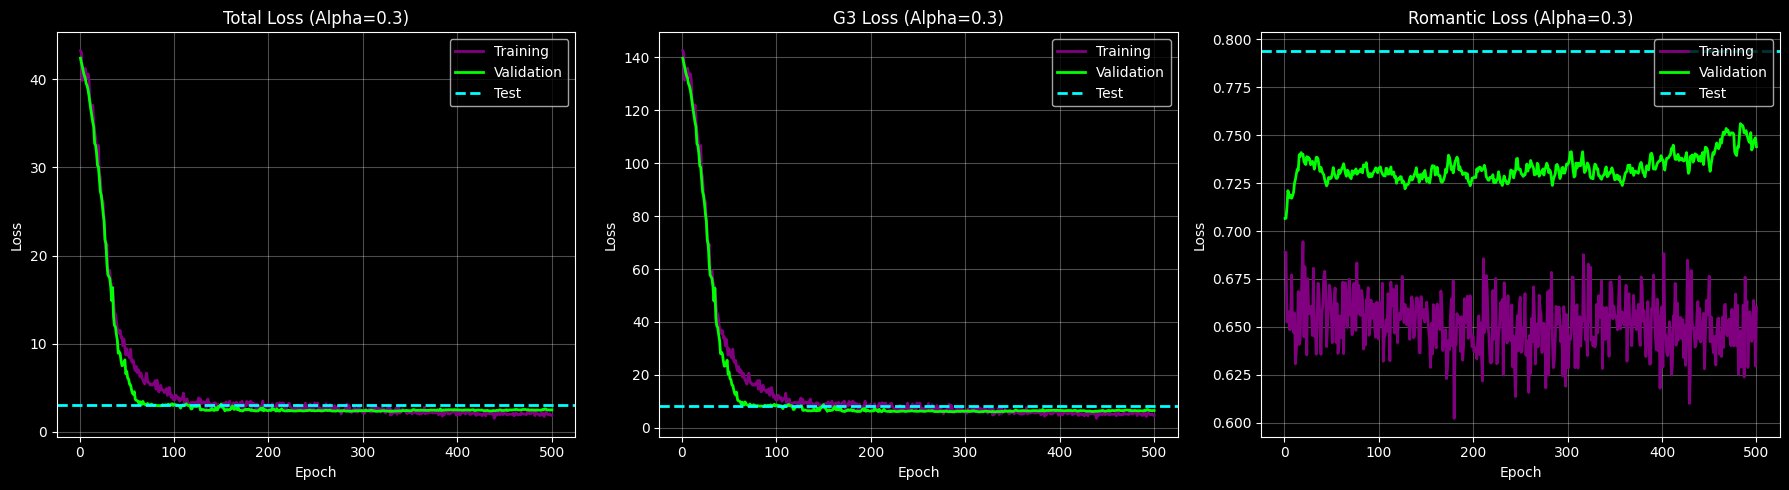

2025-11-15 15:16:58,622 - INFO - ============================================================
2025-11-15 15:16:58,624 - INFO - FINAL LOSS COMPARISON FOR ALPHA = 0.3
2025-11-15 15:16:58,625 - INFO - ============================================================
2025-11-15 15:16:58,626 - INFO - Total Loss:
2025-11-15 15:16:58,627 - INFO -   Training: 1.861
2025-11-15 15:16:58,629 - INFO -   Validation: 2.484
2025-11-15 15:16:58,630 - INFO -   Test: 3.074
2025-11-15 15:16:58,631 - INFO - G3 Loss:
2025-11-15 15:16:58,632 - INFO -   Training: 4.661
2025-11-15 15:16:58,633 - INFO -   Validation: 6.544
2025-11-15 15:16:58,634 - INFO -   Test: 8.395
2025-11-15 15:16:58,635 - INFO - Romantic Loss:
2025-11-15 15:16:58,636 - INFO -   Training: 0.660
2025-11-15 15:16:58,636 - INFO -   Validation: 0.744
2025-11-15 15:16:58,637 - INFO -   Test: 0.794
2025-11-15 15:16:58,638 - INFO - ============================================================
2025-11-15 15:16:58,638 - INFO - ==========================

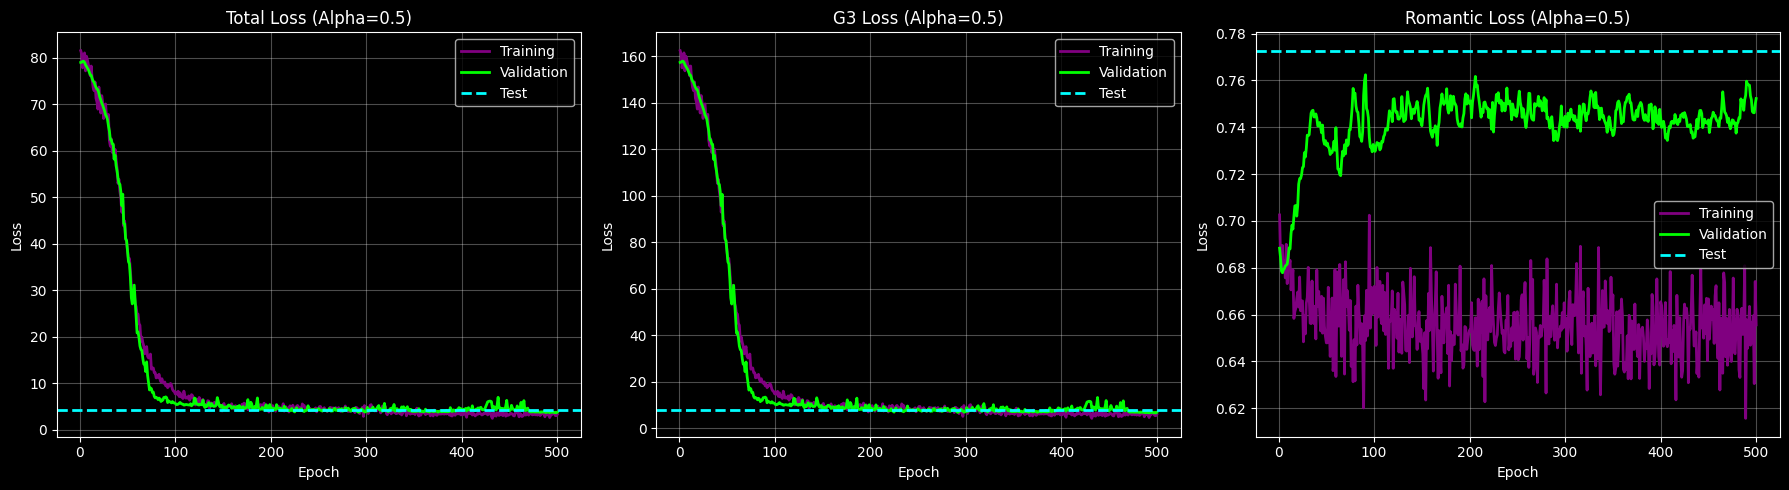

2025-11-15 15:16:59,323 - INFO - ============================================================
2025-11-15 15:16:59,325 - INFO - FINAL LOSS COMPARISON FOR ALPHA = 0.5
2025-11-15 15:16:59,327 - INFO - ============================================================
2025-11-15 15:16:59,328 - INFO - Total Loss:
2025-11-15 15:16:59,330 - INFO -   Training: 3.333
2025-11-15 15:16:59,331 - INFO -   Validation: 3.807
2025-11-15 15:16:59,331 - INFO -   Test: 4.252
2025-11-15 15:16:59,332 - INFO - G3 Loss:
2025-11-15 15:16:59,333 - INFO -   Training: 6.010
2025-11-15 15:16:59,334 - INFO -   Validation: 6.861
2025-11-15 15:16:59,335 - INFO -   Test: 7.732
2025-11-15 15:16:59,336 - INFO - Romantic Loss:
2025-11-15 15:16:59,337 - INFO -   Training: 0.656
2025-11-15 15:16:59,338 - INFO -   Validation: 0.752
2025-11-15 15:16:59,340 - INFO -   Test: 0.773
2025-11-15 15:16:59,342 - INFO - ============================================================
2025-11-15 15:16:59,343 - INFO - ==========================

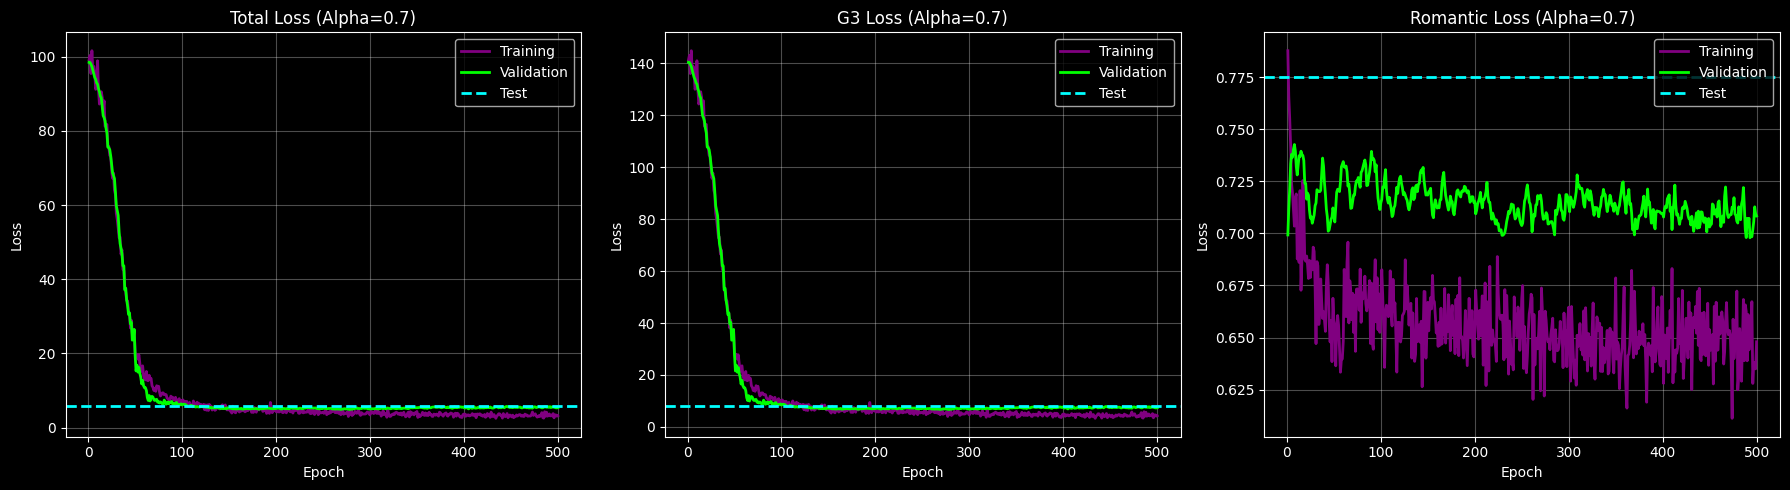

2025-11-15 15:17:00,001 - INFO - ============================================================
2025-11-15 15:17:00,002 - INFO - FINAL LOSS COMPARISON FOR ALPHA = 0.7
2025-11-15 15:17:00,003 - INFO - ============================================================
2025-11-15 15:17:00,004 - INFO - Total Loss:
2025-11-15 15:17:00,005 - INFO -   Training: 3.207
2025-11-15 15:17:00,006 - INFO -   Validation: 5.378
2025-11-15 15:17:00,007 - INFO -   Test: 5.823
2025-11-15 15:17:00,009 - INFO - G3 Loss:
2025-11-15 15:17:00,011 - INFO -   Training: 4.303
2025-11-15 15:17:00,012 - INFO -   Validation: 7.380
2025-11-15 15:17:00,012 - INFO -   Test: 7.986
2025-11-15 15:17:00,014 - INFO - Romantic Loss:
2025-11-15 15:17:00,015 - INFO -   Training: 0.648
2025-11-15 15:17:00,015 - INFO -   Validation: 0.708
2025-11-15 15:17:00,016 - INFO -   Test: 0.775
2025-11-15 15:17:00,017 - INFO - ============================================================
2025-11-15 15:17:00,018 - INFO - All evaluation and compari

In [21]:
alpha_values = [0.3, 0.5, 0.7]
evaluated_metrics = {}  # not really useful rn

for alpha in alpha_values:
    test_metrics = evaluate_model(alpha)
    evaluated_metrics[alpha] = test_metrics
    plot_train_vs_test_comparison(alpha, test_metrics, save_plot=False)

logger.info("All evaluation and comparison plotting completed!")

## Summary

Looking at the training dynamics across different $\alpha$ values, we can see how the weight parameter fundamentally changes what the model prioritizes. With $\alpha=0.3$, the model places more emphasis on the `romantic` classification task (70% weight), which shows up in the loss curves - the `romantic` loss drops quickly and stabilizes around 0.65 during training, while the `G3` loss converges to about 4.66. The validation curves follow similar patterns, though there's a noticeable gap suggesting some overfitting. Interestingly, despite prioritizing classification, the test accuracy is only 36.9%, which is actually just predicting the minority class every time.

When we move to $\alpha=0.5$, giving equal weight to both tasks, something weird happens. The training losses for both tasks get worse compared to $\alpha=0.3$ - `G3` loss increases to 6.01 and `romantic` loss stays around 0.66. The validation losses also climb higher, and the test performance remains stuck at 36.9% accuracy with an F1-score of 0 for the majority class. This suggests the model is struggling to find a good compromise between the two objectives when they're balanced.

At $\alpha=0.7$, we're now prioritizing `G3` prediction (70% weight), and the training `G3` loss improves to 4.30, but the validation `G3` loss actually explodes to 7.38, showing severe overfitting on the regression task. The `romantic` classification performance stays exactly the same - still predicting only one class. What's particularly striking across all three configurations is that the `romantic` classification never learns to distinguish between classes properly, consistently achieving 0.539 F1 for `"yes"` and 0 for `"no"`.

Given the results, $\alpha=0.7$ achieves the lowest `G3` MAE at 2.021 points, making it the best choice if `G3` prediction is the primary objective. However, all three models fail catastrophically at `romantic` classification, consistently predicting only the minority class with 36.9% accuracy. If we must choose one model for production, $\alpha=0.3$ offers the best compromise with reasonable `G3` performance (2.061 MAE) and slightly lower overfitting on the `romantic` task, even though the classification remains essentially useless.

The core issue here seems to be that the shared representation learned by the network isn't rich enough to support both tasks simultaneously. The validation and test losses are consistently higher than training losses across all $\alpha$ values, and the `romantic` classifier's complete failure to predict the majority class suggests class imbalance is overwhelming the learning signal. The MAE for `G3` stays relatively stable around 2.0-2.1 points regardless of alpha, which is decent but could be better given the scale is 0-20.